# FEM L-shape

## Question
Solve the following equation using MES:

$$\Delta u = 0 \text{ on } \Omega$$
therefore: $$\sum_{n=1}^{\infty} 2^{-n} = 1$$
and boundary values:
$$ u = 0 \text{ on } \Gamma_D$$

$$\frac{\partial u}{\partial n} = g \text{ on } \Gamma_D$$
(derivative in normal direction relatively to the boundary, given by $g$ function)

Where $\Omega$ is an area in the shape of reversed letter $L$.

$$R^2 \ni (x_1, x_2) \rightarrow u(x_1, x_2) \in R$$
is temperature function we are looking for.

$g$ is a function given in polar coordinates with beginning in the point $(0, 0)$
$$R \times (0, 2\Pi) \ni (r, \theta) \rightarrow g(r, \theta) = r^\frac{2}{3}sin^\frac{2}{3}\left(\theta + \frac{\Pi}{2}\right)$$

### Weak formulation
$$b(u,v) = l(v)\;\;\;\forall v \in V$$
$$b(u,v) = \int_\Omega \nabla u \circ \nabla v dx \text{ czyli } b(u,v) = \int_\Omega \sum_{i=1}^2 \frac{\partial u_i}{\partial x_i} \frac{\partial v_i}{\partial x_i}dx$$
$$l(v) = \int_{\Gamma_N} g\,v\,dS$$
$$V = \{v \in H^1(\Omega): w = 0 \text{ na } \Gamma_D\}$$

Solution depends on building mesh of finite elements.

### Equations system
We generate equations system:
$$u \approx u_h = \sum_{i=1}^N a_i e_i$$
$$\sum_{i=1}^N a_i b(e_i, e_j) = l(e_j)\;\;\;j=1,...,N$$
$$b(e_i, e_j) = \int_\Omega \nabla e_i \nabla e_j dx = \int_\Omega \sum_{k=1}^2 \frac{\partial e_i}{\partial x_k} \frac{\partial e_j}{\partial x_k}dx$$
$$l(e_j) = \int_{\Gamma_N}e_jg\,dS$$

The last thing is enforcing Dirichlet's and Neumann's boundary conditions by zeroing related rows and columns and calculating with the use of $g$.

## Parameter, imports

In [35]:
N = 50

In [36]:
import math
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import matplotlib.pyplot as plt

if N < 1: raise ValueError('N cannot be lower than 1')

## Dependencies

In [37]:
number_of_elements = 3 * N ** 2
elements_in_top_row = 2 * N ** 2
number_of_vertices = (2 * N + 1) * (N + 1) + N * (N + 1)

## Helper functions

In [38]:
def e_to_vertex_top_left(e):
    if e >= number_of_elements:
        raise ValueError('Vertex out of range')
    elif e < elements_in_top_row:
        return e // (2 * N) * (2 * N + 1) + e % (2 * N)
    else:
        return e // N * (N + 1) + e % N

def e_to_vertex(e, fi):
    if e >= number_of_elements:
        raise ValueError('Vertex out of range')
    elif fi == 0:
        if e < elements_in_top_row:
            return e_to_vertex(e, 3) + 2 * N + 1
        else:
            return e_to_vertex(e, 3) + N + 1
    elif fi == 1:
        return e_to_vertex(e, 0) + 1
    elif fi == 2:
        return e_to_vertex(e, 3) + 1
    else:
        return e_to_vertex_top_left(e)

In [39]:
def position_vector(e):
    if e < elements_in_top_row:
        col_no = e % (2 * N)
        row_no = e // (2 * N)
        if col_no < 2:
            b1 = - (N - col_no) / N
            b2 = (N - row_no - 1) / N
        else:
            b1 = (col_no - N) / N
            b2 = (N - row_no - 1) / N
    else:
        col_no = e % N
        row_no = (e - elements_in_top_row) // N
        b1 = (col_no) / N
        b2 = - (row_no + 1) / N
    return (b1, b2)

## Functions $\phi_i$

$a_1 = a_2 = \frac{1}{N}$ and $(b_1, b_2)$ is a position of element and will be calculated later on.

For the momment I will assume they are additional parameters of function $\phi_i$.

$$\phi_{0}(x_1,x_2) = \left(1 - \frac{x_1 - b_1}{a_1}\right)\left(1 - \frac{x_2 - b_2}{a_2}\right)$$
$$\phi_{1}(x_1,x_2) = \left(\frac{x_1 - b_1}{a_1}\right)\left(1 - \frac{x_2 - b_2}{a_2}\right)$$
$$\phi_{2}(x_1,x_2) = \left(\frac{x_1 - b_1}{a_1}\right)\left(\frac{x_2 - b_2}{a_2}\right)$$
$$\phi_{3}(x_1,x_2) = \left(1 - \frac{x - b_1}{a_1}\right)\left(\frac{x_2 - b_2}{a_2}\right)$$

From the above we can conclude:
$$\left(1 - \frac{x_1 - b_1}{a_1}\right) = 1 - \frac{1}{a_1} x_1 + \frac{b_1}{a_1}$$
$$ \implies \frac{\partial \phi_i}{\partial x_j} = \pm \frac{1}{a_j}$$

Therefore:
$$
\begin{align*}
\frac{\partial \phi_0}{\partial x_1} &= -\frac{1}{a_1} &\frac{\partial \phi_0}{\partial x_2} = -\frac{1}{a_2} \\
\frac{\partial \phi_1}{\partial x_1} &= \frac{1}{a_1}  &\frac{\partial \phi_1}{\partial x_2} = -\frac{1}{a_2} \\
\frac{\partial \phi_2}{\partial x_1} &= \frac{1}{a_1}  &\frac{\partial \phi_2}{\partial x_2} = \frac{1}{a_2} \\
\frac{\partial \phi_3}{\partial x_1} &= -\frac{1}{a_1} &\frac{\partial \phi_3}{\partial x_2} = \frac{1}{a_2}
\end{align*}
$$

Calculating partial derivatives $\phi_i$ shows that they are constant (dependent on parameter $N$ which we can treat like a constant) with alternating signs.

Therefore I can store signs as two vectors and final signs will come from linear combination of such equations system.

In [40]:
signs_for_x1 = [-1, 1, 1, -1]
signs_for_x2 = [-1, -1, 1, 1]

F_x1 = np.zeros((4, 4))
for i in range(0, 4):
    for j in range(0, 4):
        F_x1[i][j] = signs_for_x1[i] * signs_for_x1[j]
        
F_x2 = np.zeros((4, 4))
for i in range(0, 4):
    for j in range(0, 4):
        F_x2[i][j] = signs_for_x2[i] * signs_for_x2[j]
        
signs_for_x1, signs_for_x2, F_x1, F_x2

([-1, 1, 1, -1], [-1, -1, 1, 1], array([[ 1., -1., -1.,  1.],
        [-1.,  1.,  1., -1.],
        [-1.,  1.,  1., -1.],
        [ 1., -1., -1.,  1.]]), array([[ 1.,  1., -1., -1.],
        [ 1.,  1., -1., -1.],
        [-1., -1.,  1.,  1.],
        [-1., -1.,  1.,  1.]]))

In [52]:
phis = [
    lambda x_1, x_2, b1, b2: (1 - (x_1 - b1) / ( 1 / N)) * (1 - (x_2 - b2) / ( 1 / N)),
    lambda x_1, x_2, b1, b2: (x_1 - b1) / ( 1 / N) * (1 - (x_2 - b2) / ( 1 / N)),
    lambda x_1, x_2, b1, b2: (x_1 - b1) / ( 1 / N) * (x_2 - b2) / ( 1 / N),
    lambda x_1, x_2, b1, b2: (1 - (x_1 - b1) / ( 1 / N)) * (x_2 - b2) / ( 1 / N)
]

## Neumann's edge

Normal derivative on the edge $\Gamma_N$ given with a function:
$$g(r,\theta) = r^\frac{2}{3} \sin^\frac{2}{3}(\theta+\frac{\pi}{2}) = (r \sin(\theta+ \frac{\pi}{2}))^\frac{2}{3}$$

We are using trigonometric identity and translating to Cartesian co-ordinates.
$$ r \sin\left(\theta+ \frac{\pi}{2}\right) = 
r\cos\theta =
\left|\begin{array} {lcl} x_1=r\cos\theta \end{array}\right| = 
x_1
$$
Function $g$ takes final form: $g(x_1,x_2)=\sqrt[3]{x_1^2}$

In [42]:
g = lambda x_1, x_2: ((x_1) ** 2) ** (1 / 3)

We devide edge $\Gamma_N$ into separate edges (two for each element).
Value of $l(\phi^k_j)$ is approximated as function in the middle of edge multiplied by its width (equal $\frac{1}{N}$):
$$ l(\phi^k_j) \approx g(x_0,y_0)\,\phi^k_j(x_0,y_0)\,\left|\,\mathrm{edge}\,\right| $$

### Calculating vertices at Neumanns edges

In [43]:
neumanns = []
for i in range(0, number_of_elements):
    points = []
    half = 1 / (2 * N)
    
    # Left column
    if i % (2 * N) == 0 and i < elements_in_top_row:
        points.append((-1, 1 - (i // (2 * N) * (1 / N) + half)))
    
    # First row
    if i < 2 * N:
        points.append((i * 1 / N + half - 1, 1))

    # Last row
    if i >= number_of_elements - N:
        points.append(((i % N) * 1 / N + half, -1))

    # Right column
    if i % (2 * N) == 2 * N - 1 and i <= elements_in_top_row:
        points.append((1, 1 - (i // (2 * N) * (1 / N) + half)))
    if i == number_of_elements - 1 or (i - elements_in_top_row) % N == N - 1 and i > elements_in_top_row: 
        points.append((1, -((i - elements_in_top_row) // N * (1 / N) + half)))
    neumanns.append(points)

# neumanns

## Calculating matrices

In [44]:
B = np.zeros((number_of_vertices, number_of_vertices))
L = np.zeros(number_of_vertices)

for e in range(0, number_of_elements):
    b1, b2 = position_vector(e)
    for i in range(0, 4):
        i1 = e_to_vertex(e, i)
        
        # Calculate L for vertices on Neumann's edge.
        # Note: others will stay 0.
        for x_1, x_2 in neumanns[e]:
            L[i1] += g(x_1, x_2) * phis[i](x_1, x_2, b1, b2) * (1 / N)
        
        # Use formula from weak formulation
        for j in range(0, 4):
            j1 = e_to_vertex(e, j)
            B[i1][j1] += (F_x1[i][j] + F_x2[i][j]) * 0.25
    
B, L

(array([[ 0.5,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  1. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
        ..., 
        [ 0. ,  0. ,  0. , ...,  1. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  1. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0.5]]),
 array([ 0.01993322,  0.01973221,  0.01946281, ...,  0.01946281,
         0.01973221,  0.01993322]))

## Dirichlet edges
Zeroing of specific rows and columns.

In [45]:
for i in range((2 * N + 1) * N, (2 * N + 2) * N):
    L[i] = 0
    B[i,:] = 0
    B[i,i] = 1

for i in range((2 * N + 2) * N, number_of_vertices - N, N + 1):
    L[i] = 0
    B[i,:] = 0
    B[i,i] = 1

## Solving linear s

In [46]:
a = np.linalg.solve(B, L)
a

array([ 1.75115843,  1.73388471,  1.71095268, ...,  1.79964886,
        1.82407678,  1.8421055 ])

## Sampling value of function

Function $u$, which is the solution to the previously defined problem is a linear combination of basis functions $e$.

$$u(x_1,x_2) = \sum_{i=0}^{3N^2} a_i e_i (x_1,x_2)$$
Coefficients of this combination are the solution of the previously calculated system of equations. Values of $e$ are sums of each local function. Inside given element $E$, value of $u$ is linear combination of local function with specific coefficients.

### Helper function

In [47]:
def coord_to_e(x, y):
    w = 1 / N
    if y > 0:
        r = (1 - y) // w * 2 * N + (x + 1) // w
    elif y < 0:
        r = elements_in_top_row + -y // w * N + x // w
    return min(math.floor(r), number_of_elements - 1)

### Plot

In [48]:
sampling_n = 50

if sampling_n % 2 != 0:
    raise ValueError("Sampling should be even value. You can either make it unrelated to N (or round it in a way) or choose another N")

# sample
xs = np.linspace(-1, 1, sampling_n)
ys = np.linspace(-1, 1, sampling_n)

# values
Z = np.zeros((len(xs), len(ys)))

for (i, x) in enumerate(xs):
    for (j, y) in enumerate(ys): 
        if x <= 0 and y <= 0: continue
            
        k = coord_to_e(x, y)
        b1, b2 = position_vector(k)
        
        # e_i function represented as linear combination of phi_f
        for f in range(0, 4):
            Z[i, j] += a[e_to_vertex(k, f)] * phis[f](x, y, b1, b2)
Z

array([[ 0.        ,  0.        ,  0.        , ...,  1.66960407,
         1.7106571 ,  1.75115843],
       [ 0.        ,  0.        ,  0.        , ...,  1.6294755 ,
         1.67030659,  1.71025338],
       [ 0.        ,  0.        ,  0.        , ...,  1.59058455,
         1.63083954,  1.6698803 ],
       ..., 
       [ 1.7513926 ,  1.71470829,  1.68149444, ...,  2.21233833,
         2.24869256,  2.28637108],
       [ 1.79882624,  1.76123833,  1.72745557, ...,  2.25501207,
         2.29190983,  2.3304778 ],
       [ 1.8421055 ,  1.80396331,  1.76996016, ...,  2.29635539,
         2.33345889,  2.37257045]])

In [49]:
X, Y = np.meshgrid(xs, ys)

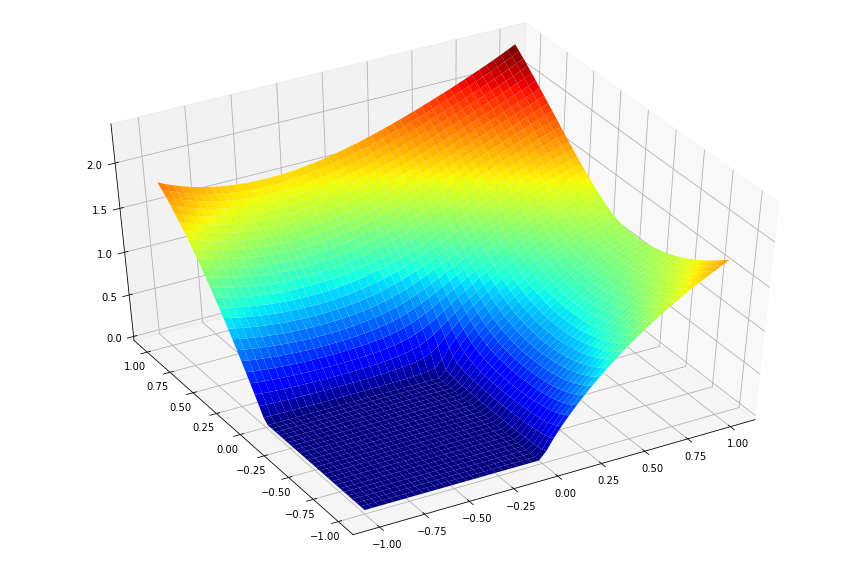

In [50]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca(projection = '3d')
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = plt.get_cmap('jet'))
ax.view_init(45, -120)

plt.show()

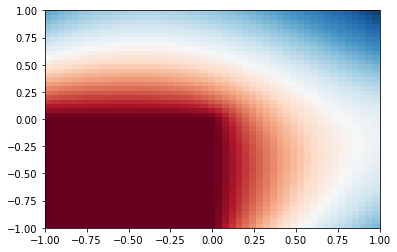

In [51]:
fig, ax = plt.subplots()
p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
plt.show()

Looks good to me 😁👌